<a href="https://colab.research.google.com/github/augustgresens/AI-Final/blob/main/presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview
The goal of this project is to create a model capable of correctly identifying the animals when given an image using the Animals 151 dataset.

# Set Up

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
import os
import json

# Extracting dataset from zip file
zip_path = '/content/drive/My Drive/archive.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

print("Root Directory Contents:", os.listdir('/content/dataset'))

# Setting up dataset directories
base_dir = '/content/dataset'
data_dir = os.path.join(base_dir, 'dataset')
final_dataset_dir = os.path.join(data_dir, 'dataset')

# Changing class names
translation_file = '/content/dataset/translation.json'
with open(translation_file, 'r') as file:
    translation_dict = json.load(file)

Root Directory Contents: ['dataset', 'translation.json']


In [ ]:
scientific_class_names = ['equus-quagga', 'panthera-leo', 'ursus-arctos-horribilis']

common_class_names = [translation_dict[name] for name in scientific_class_names if name in translation_dict]

print(common_class_names)


['Plains Zebra', 'Lion', 'Grizzly Bear']


In [ ]:
import tensorflow as tf

img_height = 224
img_width = 224
batch_size = 32

# Loading and preprocessing training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    final_dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Translate class names to common names
class_names = [translation_dict.get(name, name) for name in train_ds.class_names]
print("Class Names:", class_names)

train = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Loading and preprocessing validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    final_dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6270 files belonging to 151 classes.
Using 5016 files for training.
Class Names: ['Cheetah', 'Crested Auklet', 'Tree Frog', 'Eastern Copperhead', 'Giant Panda', 'Red Panda', 'Moose', 'Mallard', 'Ankylosaurus', 'Western Honey Bee', 'Emperor Penguin', 'Golden Eagle', 'Scarlet Macaw', 'Giant Squid', 'Great Blue Heron', 'Blue Whale', 'Siamese Fighting Fish', 'American Bison', 'Gaur', 'Domestic Cow', 'Brown-throated Three-toed Sloth', 'Canada Goose', 'Wolf', 'Domestic Dog', 'Great White Shark', 'Northern Cardinal', 'Turkey Vulture', 'African Spurred Tortoise', 'Striped Bark Scorpion', 'Mediterranean Fruit Fly', 'White Rhino', 'Green Sea Turtle', 'Painted Turtle', 'Northern Harrier', "Dead Man's Fingers", 'Coelacanth', 'Northern Flicker', 'Wildebeest', 'Crested Giant Gecko', 'Crocodile', 'Western diamondback rattlesnake', 'Groove-billed Ani', 'Fossa', 'Blue Jay', 'Monarch Butterfly', 'Nine-banded Armadillo', 'Beluga', 'Poison Dart Frog', 'Leatherback Sea Turtle', 'Vampire Bat', 'Diplod

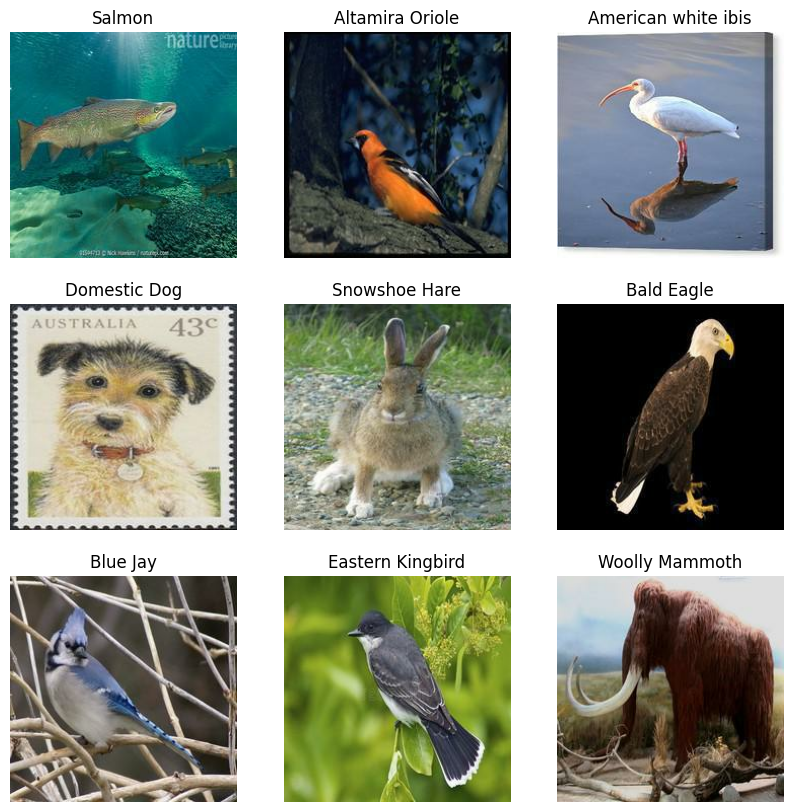

In [ ]:
import matplotlib.pyplot as plt

for images, labels in train.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        label_index = labels[i].numpy()
        plt.title(class_names[label_index])
        plt.axis('off')
    plt.show()


# First Attempt
Defined a Convolutional Neural Network.
Added layers for rescaling to normalize, convolutional layers to extract features, max pooling to reduce layers and retain the most important information, flattening to make it easier to process information, and dense layers to find relationships.  This run topped out at 17.62% validation accuracy.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(151, activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [ ]:
epochs = 10
history = model.fit(
    train,
    validation_data=val,
    epochs=epochs
)

Epoch 1/10
157/157 [==============================] - 13s 52ms/step - loss: 4.8734 - accuracy: 0.0213 - val_loss: 4.7006 - val_accuracy: 0.0367
Epoch 2/10
157/157 [==============================] - 5s 32ms/step - loss: 4.3932 - accuracy: 0.0742 - val_loss: 4.1909 - val_accuracy: 0.0989
Epoch 3/10
157/157 [==============================] - 5s 34ms/step - loss: 3.6999 - accuracy: 0.1796 - val_loss: 3.9314 - val_accuracy: 0.1467
Epoch 4/10
157/157 [==============================] - 5s 32ms/step - loss: 2.7129 - accuracy: 0.3571 - val_loss: 3.9560 - val_accuracy: 0.1762
Epoch 5/10
157/157 [==============================] - 5s 33ms/step - loss: 1.5690 - accuracy: 0.6017 - val_loss: 4.5611 - val_accuracy: 0.1730
Epoch 6/10
157/157 [==============================] - 5s 32ms/step - loss: 0.6800 - accuracy: 0.8208 - val_loss: 5.5756 - val_accuracy: 0.1699
Epoch 7/10
157/157 [==============================] - 5s 33ms/step - loss: 0.2701 - accuracy: 0.9354 - val_loss: 6.5236 - val_accuracy: 0.166

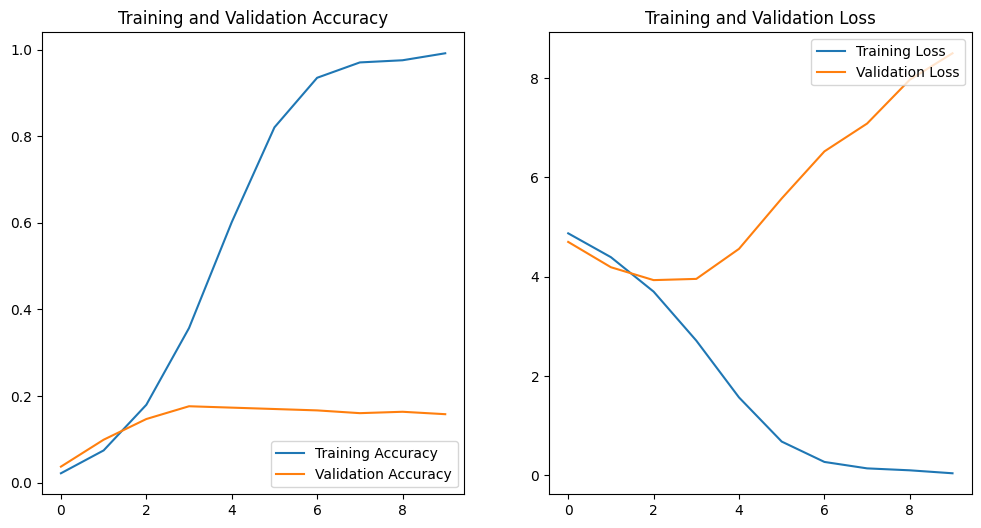

In [ ]:
# Plotting training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()


# Improvements Through Augmentation
Added image augmentation to reduce overfitting so easily.  Augmentations included random flips, rotations, brightness changes, contrast adjustments, translations, and zooms.  This helps the model learn from a more varied set of examples too, which is important with this limited dataset.  This run topped out at 29.19% validation accuracy.


In [ ]:
import tensorflow as tf

aug = tf.keras.Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.1),
  layers.RandomBrightness(0.2),
  layers.RandomContrast(0.2),
  layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
  layers.RandomZoom(0.1)
])

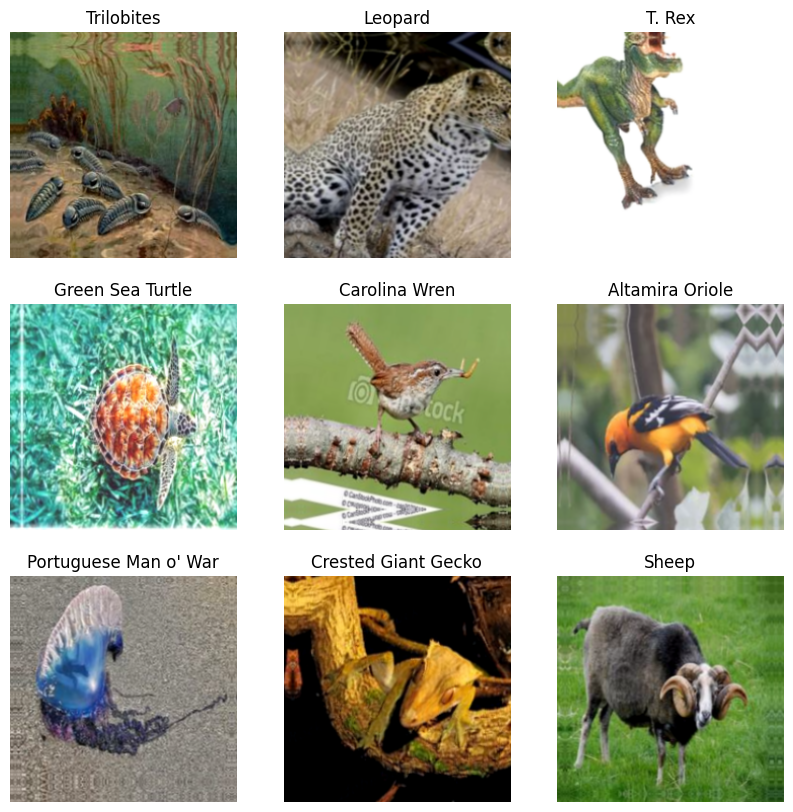

In [ ]:
# Show augmented images
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train.take(1):
    augmented_images = aug(images)

    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[i].numpy().astype('uint8'))
        label_index = labels[i].numpy()
        plt.title(class_names[label_index])
        plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([
    aug,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_ds.class_names), activation='softmax')
])

model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                

In [ ]:
epochs = 50

history = model.fit(
    train,
    validation_data=val,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/50
157/157 [==============================] - 12s 47ms/step - loss: 4.9898 - accuracy: 0.0140 - val_loss: 4.9109 - val_accuracy: 0.0183
Epoch 2/50
157/157 [==============================] - 7s 47ms/step - loss: 4.7711 - accuracy: 0.0317 - val_loss: 4.7002 - val_accuracy: 0.0415
Epoch 3/50
157/157 [==============================] - 6s 37ms/step - loss: 4.4973 - accuracy: 0.0532 - val_loss: 4.4655 - val_accuracy: 0.0566
Epoch 4/50
157/157 [==============================] - 6s 38ms/step - loss: 4.2630 - accuracy: 0.0716 - val_loss: 4.4261 - val_accuracy: 0.0742
Epoch 5/50
157/157 [==============================] - 6s 37ms/step - loss: 4.0721 - accuracy: 0.0989 - val_loss: 4.2609 - val_accuracy: 0.0901
Epoch 6/50
157/157 [==============================] - 6s 38ms/step - loss: 3.9166 - accuracy: 0.1194 - val_loss: 4.0878 - val_accuracy: 0.1244
Epoch 7/50
157/157 [==============================] - 6s 37ms/step - loss: 3.7603 - accuracy: 0.1431 - val_loss: 3.9534 - val_accuracy: 0.150

In [ ]:
val_loss, val_acc = model.evaluate(val)
print(f"Validation accuracy: {val_acc*100:.2f}%, Validation loss: {val_loss:.4f}")

40/40 [==============================] - 1s 14ms/step - loss: 3.3640 - accuracy: 0.2592
Validation accuracy: 25.92%, Validation loss: 3.3640


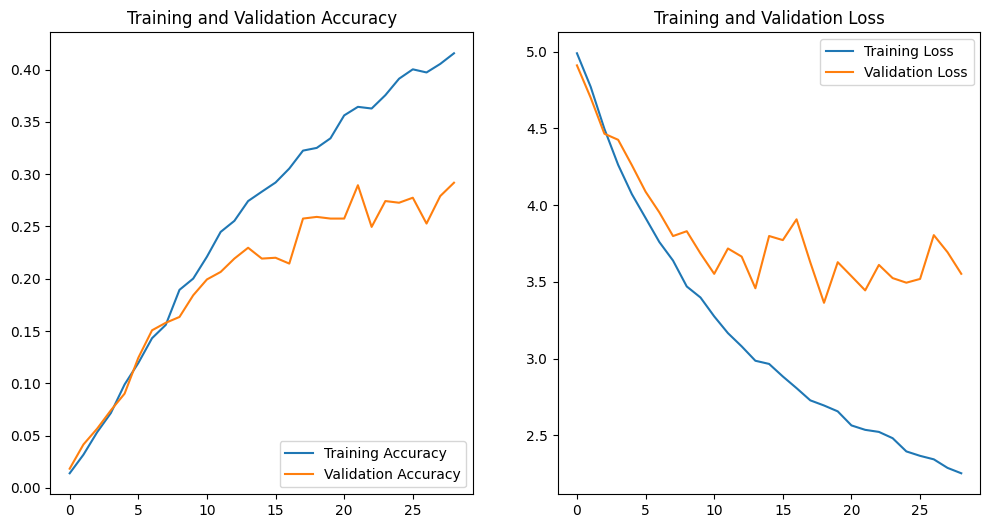

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_trained = len(acc)
epochs_range = range(epochs_trained)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()



# More Aggressive Data Augmentation
This section created an even more varied augmentation for images, to try and reduce overfitting even more.  Also attempted Batch Normalization to also help reduce overfitting, as well as ideally speeding up the training process leading to a faster convergence.  Also added dropout layers to help generalize the data better.  However, with a validation accuracy being 26.32%, it actually made the model worse. This could be because of more aggressive data augmentation, which can make some animals appear too altered.


In [ ]:
aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.3),
    layers.RandomContrast(0.3),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomZoom(0.2),
    layers.RandomCrop(img_height, img_width),
])

model = Sequential([
    aug,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(train_ds.class_names), activation='softmax')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
epochs = 150

history = model.fit(
    train,
    validation_data=val,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/150
157/157 [==============================] - 16s 75ms/step - loss: 4.9414 - accuracy: 0.0221 - val_loss: 5.8181 - val_accuracy: 0.0104
Epoch 2/150
157/157 [==============================] - 11s 72ms/step - loss: 4.5990 - accuracy: 0.0451 - val_loss: 5.5837 - val_accuracy: 0.0104
Epoch 3/150
157/157 [==============================] - 11s 73ms/step - loss: 4.4115 - accuracy: 0.0614 - val_loss: 4.7433 - val_accuracy: 0.0367
Epoch 4/150
157/157 [==============================] - 12s 73ms/step - loss: 4.2281 - accuracy: 0.0859 - val_loss: 4.2803 - val_accuracy: 0.0845
Epoch 5/150
157/157 [==============================] - 12s 74ms/step - loss: 4.0799 - accuracy: 0.1025 - val_loss: 4.0897 - val_accuracy: 0.1053
Epoch 6/150
157/157 [==============================] - 12s 74ms/step - loss: 3.9547 - accuracy: 0.1222 - val_loss: 4.3607 - val_accuracy: 0.0925
Epoch 7/150
157/157 [==============================] - 12s 74ms/step - loss: 3.8558 - accuracy: 0.1290 - val_loss: 3.8353 - val_ac

In [ ]:
val_loss, val_acc = model.evaluate(val)
print(f"Validation accuracy: {val_acc*100:.2f}%, Validation loss: {val_loss:.4f}")

40/40 [==============================] - 1s 20ms/step - loss: 3.3630 - accuracy: 0.2504
Validation accuracy: 25.04%, Validation loss: 3.3630


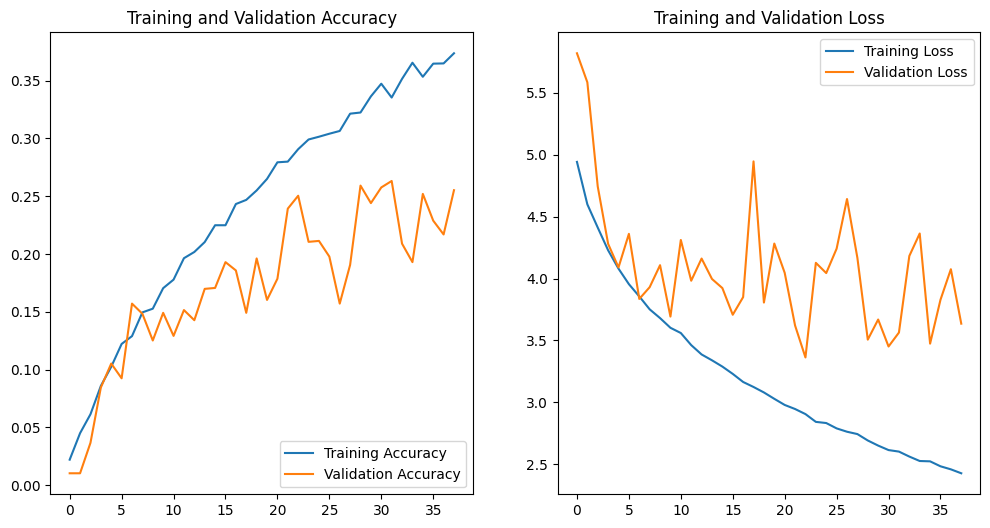

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_trained = len(acc)
epochs_range = range(epochs_trained)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()



# Added Regulizers to Simplify Model
Reduced the number of augmentation layers, as well as the intensity, to maybe help the training accuracy to improve. Also added L2 regularization to add a penalty on any weights on the model that were too large, which could help simplify the model. The validation accuracy of this section is 26.16%.

In [ ]:
from tensorflow.keras import regularizers

aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.3),
    layers.RandomContrast(0.3),
])

model = Sequential([
    aug,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(len(train_ds.class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [ ]:
epochs = 150

history = model.fit(
    train,
    validation_data=val,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/150
157/157 [==============================] - 8s 39ms/step - loss: 5.0807 - accuracy: 0.0066 - val_loss: 5.0129 - val_accuracy: 0.0080
Epoch 2/150
157/157 [==============================] - 6s 35ms/step - loss: 4.9448 - accuracy: 0.0130 - val_loss: 4.8479 - val_accuracy: 0.0120
Epoch 3/150
157/157 [==============================] - 6s 39ms/step - loss: 4.7289 - accuracy: 0.0259 - val_loss: 4.6412 - val_accuracy: 0.0287
Epoch 4/150
157/157 [==============================] - 6s 36ms/step - loss: 4.5769 - accuracy: 0.0345 - val_loss: 4.5290 - val_accuracy: 0.0367
Epoch 5/150
157/157 [==============================] - 6s 37ms/step - loss: 4.4794 - accuracy: 0.0457 - val_loss: 4.4965 - val_accuracy: 0.0415
Epoch 6/150
157/157 [==============================] - 6s 37ms/step - loss: 4.4116 - accuracy: 0.0536 - val_loss: 4.4704 - val_accuracy: 0.0582
Epoch 7/150
157/157 [==============================] - 6s 37ms/step - loss: 4.3455 - accuracy: 0.0618 - val_loss: 4.4137 - val_accuracy:

In [ ]:
val_loss, val_acc = model.evaluate(val)
print(f"Validation accuracy: {val_acc*100:.2f}%, Validation loss: {val_loss:.4f}")

40/40 [==============================] - 1s 13ms/step - loss: 3.4877 - accuracy: 0.2472
Validation accuracy: 24.72%, Validation loss: 3.4877


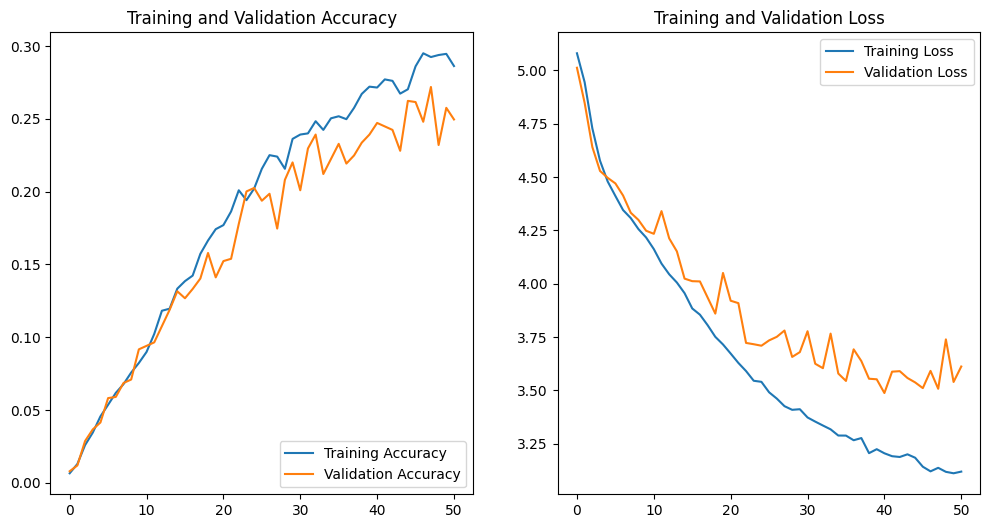

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_trained = len(acc)
epochs_range = range(epochs_trained)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()



# Final Attempt
The most important change in this section was the use of MobileNetV2, which is a pre-trained convolutional neural network that is specialized for image classifications and image feature extraction. MobileNetV2's weights can also be trainable, which allows for the fine tuning to adapt to this data. I also use L2 Regularization to punish large weights to protect against overfitting, and better generalize the data through batch normalization and dropout layers. This new strategy improved the model dramatically, as the validation accuracy is now 87.48% at it's highest, and with a validation loss of 0.7290 at it's lowest.

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import MobileNetV2

img_height = 224
img_width = 224
batch_size = 32

aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

data_dir = final_dataset_dir
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

train = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True


model = Sequential([
    aug,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(train_ds.class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


Found 6270 files belonging to 151 classes.
Using 5016 files for training.
Found 6270 files belonging to 151 classes.
Using 1254 files for validation.
9406464/9406464 [==============================] - 1s 0us/step


In [7]:
epochs = 150
history = model.fit(
    train,
    validation_data=val,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/150
157/157 [==============================] - 68s 179ms/step - loss: 7.2024 - accuracy: 0.0634 - val_loss: 6.8842 - val_accuracy: 0.0797
Epoch 2/150
157/157 [==============================] - 23s 144ms/step - loss: 5.6022 - accuracy: 0.2913 - val_loss: 5.3753 - val_accuracy: 0.3373
Epoch 3/150
157/157 [==============================] - 23s 144ms/step - loss: 4.6809 - accuracy: 0.4817 - val_loss: 4.4383 - val_accuracy: 0.5263
Epoch 4/150
157/157 [==============================] - 23s 146ms/step - loss: 4.0687 - accuracy: 0.6053 - val_loss: 3.8179 - val_accuracy: 0.6555
Epoch 5/150
157/157 [==============================] - 23s 146ms/step - loss: 3.5994 - accuracy: 0.6886 - val_loss: 3.3697 - val_accuracy: 0.7321
Epoch 6/150
157/157 [==============================] - 23s 145ms/step - loss: 3.2142 - accuracy: 0.7598 - val_loss: 3.0828 - val_accuracy: 0.7592
Epoch 7/150
157/157 [==============================] - 23s 146ms/step - loss: 2.8920 - accuracy: 0.8052 - val_loss: 2.8606 -

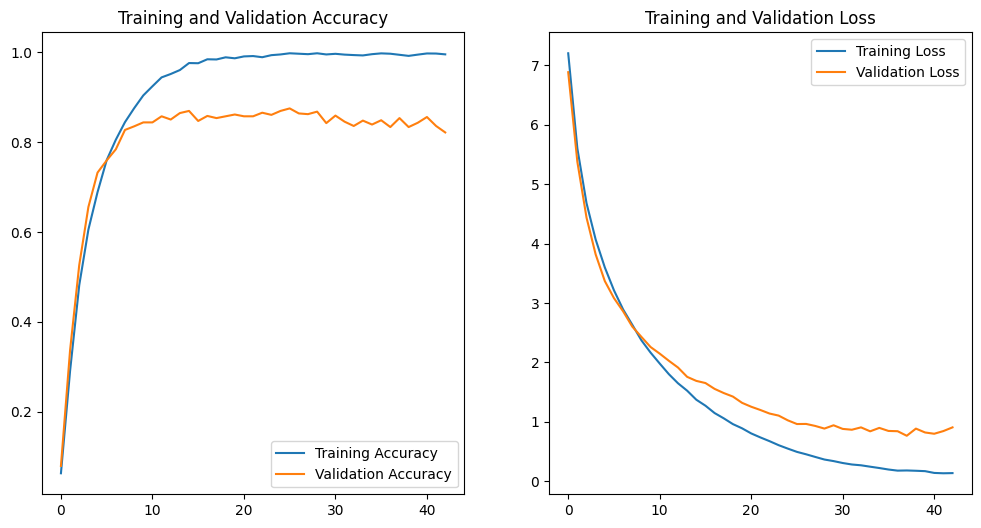

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_trained = len(acc)
epochs_range = range(epochs_trained)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

